In [5]:
import ROOT
import os
import numpy as np
import argparse

Welcome to JupyROOT 6.24/04


# Template Types

* Note: Redo Numerator - DONE
* Denominator - DONE
* Redo Real (with ID) - DONE
* Redo MCFakes (with ID)

For Closure Test first 

In [212]:
templateType = "MCFakes"
outFileName = "%s.root" %(templateType)

In [213]:
def chainFiles(templateType):
    tChain = ROOT.TChain("demo/EventTree")
  
    if (templateType == "Numerator" or "Denominator" or "MCFakes"):
        tChain.Add("nTuple_GGJets_Pt-15_13TeV-sherpa_evt71999.root")
        tChain.Add("nTuple_QCD_Pt15to7000_TuneCP5_Flat2018_pythia8_evt78000.root")
    
    if (templateType == "Real"):
        tChain.Add("nTuple_GGGJets_Pt-15_13TeV-sherpa_evt17800.root")
    
    print ('Total number of events: ' + str(tChain.GetEntries()))
    return tChain

In [214]:
tChain = chainFiles(templateType)
maxEvents = tChain.GetEntries()

Total number of events: 149999


# Selections for Template Types

In [215]:
def passNumeratorCuts(phoIDbit):
    # Everything that passes the 94X tight cutbased ID 
    passStatus = True if phoIDbit>>1&2 != 0 else False
    return passStatus  

In [216]:
def passDenominatorCuts(looseID, phoEleVeto, phoHoverE, phoPFChIso, phoSieSie, etaBin):
    # Denominator - collection of objects that passes a looser version of the 94X tight cutbased ID 
   
#     passlooserID = False
    failHoverE   = False 
    failSieie    = False 
    failChiso    = False 
    passEleVeto  = phoEleVeto
    passAdditionalHoverE = False 
    
#     if (looseID>>1&1 != 0): 
#         passlooserID = True
        
    if (phoHoverE > 0.05):
        failHoverE = True
    
    # Sieie 
    sieiecut = 0.0105 if etaBin == "EB" else 0.0280
    if (phoSieSie > sieiecut):
        failSieie = True 
    if (phoPFChIso > 5):
        failChiso = True
    
    if (phoHoverE < 0.1): 
        passAdditionalHoverE = True
        
    failAtLeastOne = failHoverE or failSieie or failChiso
    
    passStatus = passEleVeto and passAdditionalHoverE and failAtLeastOne
    
    return passStatus
    

In [217]:
def has_mcPho_match(event, pho_vec, minDr=0.3):
    min_delta_r = float('Inf')
    pid = 0 
    for mc in range(event.nMC):
        if event.mcPt[mc] > 1.0:
            mc_vec = ROOT.TLorentzVector()
            mc_vec.SetPtEtaPhiE(event.mcPt[mc], event.mcEta[mc], event.mcPhi[mc], event.mcE[mc])
            delta_r = pho_vec.DeltaR(mc_vec)
            if delta_r < min_delta_r: 
                min_delta_r = delta_r
                if delta_r < minDr:
                    pid = abs(event.mcPID[mc])
    if pid == 22: return True 
    return False

In [218]:
def passRealCuts(phoIDbit, event, pho_vec, minDr=0.3):
    passID = True if phoIDbit>>1&2 != 0 else False
    passStatus = passID and has_mcPho_match(event,  pho_vec, minDr)
    return passStatus

In [250]:
def passMCFakeCuts(phoIDbit, event, pho_vec, minDr=0.3):
    failID = True if phoIDbit>>1&2 == 0 else False
    noGenMatchReq = True if has_mcPho_match(event,  pho_vec, minDr) == False else False
    
    passStatus = failID and noGenMatchReq
    return passStatus

In [251]:
def passTemplateSelections(templateType, phoIDbit, eleVeto, HoverE, ChIso, Sieie, etaBin, event, pho_vec, minDr=0.3):
    if (templateType == "Numerator"):
        return passNumeratorCuts(phoIDbit)
    if (templateType == "Denominator"):
        return passDenominatorCuts(phoIDbit, eleVeto, HoverE, ChIso, Sieie, etaBin)
    if (templateType == "Real"):
        return passRealCuts(phoIDbit, event, pho_vec, minDr)
    if (templateType == "MCFakes"):
        return passMCFakeCuts(phoIDbit, event, pho_vec, minDr)

In [252]:
def etaBinStr(phoEta):
    if (abs( phoEta < 1.4442 )):
        return "EB"
    if (1.5666 < phoEta < 2.5):
        return "EE"

# Fill Templates

In [253]:
fileOut = ROOT.TFile(outFileName, 'RECREATE')

In [254]:
nbinsSieieEB = 50 # 200 for data, 50 for closure test
nbinsSieieEE = 25 # 100 for data, 25 for closure test
nbinsChIso   = 50 # 100 for data, 50 for closure test

In [255]:
# FIX ME: Turn this into an array and then for loop of histograms based on pT sidebands later if we need to
hSieieEB_pT15_30  = ROOT.TH1D( 'hSieieEB%s_pT15_30'  %(templateType), 'sieieEB', nbinsSieieEB, 0., 0.1)
hSieieEB_pT30_50  = ROOT.TH1D( 'hSieieEB%s_pT30_50'  %(templateType), 'sieieEB', nbinsSieieEB, 0., 0.1)
hSieieEB_pT50_70  = ROOT.TH1D( 'hSieieEB%s_pT50_70'  %(templateType), 'sieieEB', nbinsSieieEB, 0., 0.1)
hSieieEB_pT70_90  = ROOT.TH1D( 'hSieieEB%s_pT70_90'  %(templateType), 'sieieEB', nbinsSieieEB, 0., 0.1 )
hSieieEB_pT90_110 = ROOT.TH1D( 'hSieieEB%s_pT90_110' %(templateType), 'sieieEB', nbinsSieieEB, 0., 0.1 )
hSieieEB_pT110_130 = ROOT.TH1D( 'hSieieEB%s_pT110_130' %(templateType), 'sieieEB', nbinsSieieEB, 0., 0.1 )

In [256]:
hSieieEB_pT15_30.Sumw2()
hSieieEB_pT30_50.Sumw2()
hSieieEB_pT50_70.Sumw2()
hSieieEB_pT70_90.Sumw2()
hSieieEB_pT90_110.Sumw2()
hSieieEB_pT110_130.Sumw2()

In [257]:
for ievent, event in enumerate(tChain):
    if ievent > maxEvents and maxEvents != -1: break 
    if ievent % 10000 == 0: print ('Processing entry ' + str(ievent))
    
    for i in range(event.nPho):
        phoE     = event.phoE[i]
        phoPt    = event.phoEt[i]
        phoIDbit = event.phoIDbit[i]
        eleVeto  = event.phoEleVeto[i]
        HoverE   = event.phoHoverE[i]
        ChIso    = event.phoPFChIso[i]
        Sieie    = event.phoSigmaIEtaIEtaFull5x5[i]
        phoEta   = event.phoEta[i]
        phoPhi   = event.phoPhi[i]
        etaBin   = etaBinStr(phoEta)
        pho_vec  = ROOT.TLorentzVector()
        pho_vec.SetPtEtaPhiE(phoPt, phoEta, phoPhi, phoE)
        minDr    = 0.3
        
        
        if (passTemplateSelections(templateType, phoIDbit, eleVeto, HoverE, ChIso, Sieie, etaBin, event, pho_vec, minDr)):
            # Fill Histograms
            if ( 15 < phoPt < 30 ):
                hSieieEB_pT15_30.Fill(Sieie)
            if ( 30 < phoPt < 50 ):
                hSieieEB_pT30_50.Fill(Sieie)
            if ( 50 < phoPt < 70 ):
                hSieieEB_pT50_70.Fill(Sieie)
            if ( 70 < phoPt < 90 ):
                hSieieEB_pT70_90.Fill(Sieie)
            if ( 90 < phoPt < 110 ):
                hSieieEB_pT90_110.Fill(Sieie)
            if ( 110 < phoPt < 130 ):
                hSieieEB_pT110_130.Fill(Sieie)

fileOut.Write()
fileOut.Close()
print('DONE - %s Templates' %(templateType)) 

Processing entry 0
Processing entry 10000
Processing entry 20000
Processing entry 30000
Processing entry 40000
Processing entry 50000
Processing entry 60000
Processing entry 70000
Processing entry 80000
Processing entry 90000
Processing entry 100000
Processing entry 110000
Processing entry 120000
Processing entry 130000
Processing entry 140000
DONE - MCFakes Templates


# Check Templates

for quick debugging

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/MCFakesComparisons.pdf has been created


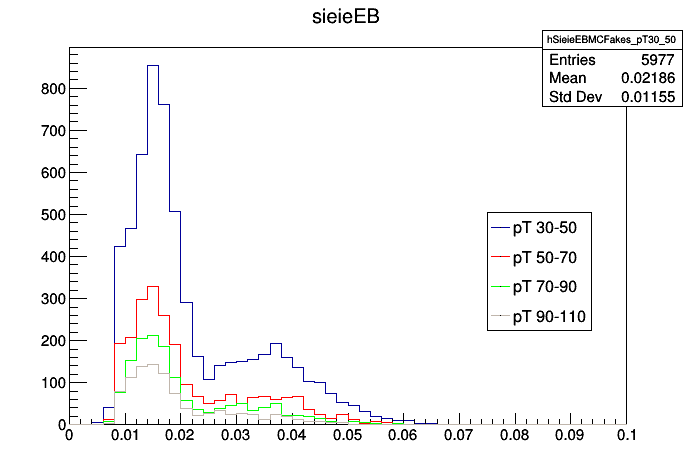

In [258]:
f = ROOT.TFile("%s.root" %(templateType), "READ")

hTempSieiePT30_50 = f.Get("hSieieEB%s_pT30_50" %(templateType))
hTempSieiePT50_70 = f.Get("hSieieEB%s_pT50_70" %(templateType))
hTempSieiePT70_90  = f.Get("hSieieEB%s_pT70_90" %(templateType))
hTempSieiePT90_110 = f.Get("hSieieEB%s_pT90_110" %(templateType))

c = ROOT.TCanvas("c")
c.cd()

hTempSieiePT30_50.Draw("HIST") 
hTempSieiePT50_70.SetLineColor(2)
hTempSieiePT50_70.Draw("HIST, SAME")
hTempSieiePT70_90.SetLineColor(3)
hTempSieiePT90_110.SetLineColor(11)
hTempSieiePT70_90.Draw("HIST, SAME")
hTempSieiePT90_110.Draw("HIST, SAME")

legend = ROOT.TLegend(0.7, 0.3, 0.85, 0.55)
legend.AddEntry(hTempSieiePT30_50, "pT 30-50")
legend.AddEntry(hTempSieiePT50_70, "pT 50-70")
legend.AddEntry(hTempSieiePT70_90, "pT 70-90")
legend.AddEntry(hTempSieiePT90_110, "pT 90-110")
legend.Draw("SAME")

c.Draw()
c.SaveAs('plots/%sComparisons.pdf' %(templateType))